<font color='blue'> **01 _____________________________________________________________________________** </font> 

In [ ]:
import numpy as np ; import gstools as gs; from gstools.random import MasterRNG ; import matplotlib.pyplot as plt ; import matplotlib ; from matplotlib import cm 
import pandas as pd; from pathlib import Path        ; _R=Path("_R")  ;_R.mkdir(exist_ok=True) ; TA=Path("_R/C01")  ;TA.mkdir(exist_ok=True) ; from pykrige.uk3d import UniversalKriging3D 
import pykrige.kriging_tools as kt                   ; from pykrige.ok import OrdinaryKriging   ; from pykrige.uk import UniversalKriging ; from pykrige.ok3d import OrdinaryKriging3D

import pyvista as pv ; import vtk  ; from vtk.util.numpy_support import numpy_to_vtk    # https://scikit-learn.org/stable/user_guide.html

<font color='blue'> **____________________________________________________________________ Krig 1D** </font> 

5.02 -5.01 1.69 -2.05


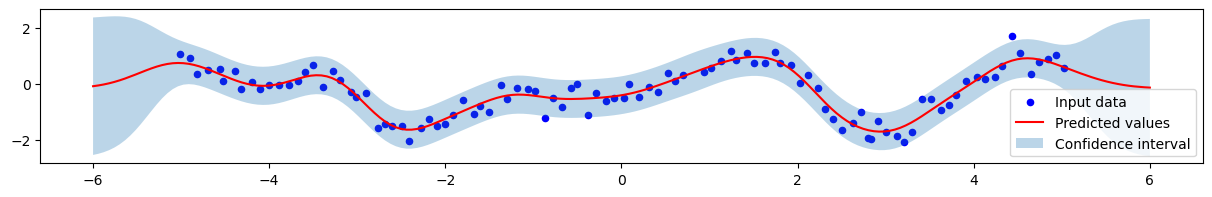

In [33]:
REF1=Path('E:/15_REPOS/05_Working/11e_Kriging_Beta/data') ; XX = np.loadtxt(REF1/'x.txt') ; YY = np.loadtxt(REF1/'y.txt')             # np.savetxt(TA/'x.txt', X, fmt='%.3f')  
XP = np.linspace(-6, 6, 200)                              ; print (XX.max(), XX.min(), YY.max(), YY.min()) ; XX.shape                          
uk = OrdinaryKriging(XX, np.zeros(XX.shape), YY, variogram_model='gaussian') ; YP, Y_STD = uk.execute("grid", XP, np.array([0.0]))    ; YP = np.squeeze(YP)  ; Y_STD = np.squeeze(Y_STD)

fig, ax = plt.subplots(1, 1, figsize=(15, 2))  ; ax.scatter(XX, YY, s=20, label="Input data", color='b')          ; ax.plot(XP, YP, label="Predicted values", color='r')
ax.fill_between(XP,YP - 3 * Y_STD,YP + 3 * Y_STD,alpha=0.3,label="Confidence interval",); ax.legend(loc=4)        ; #ax.set_xlim(-6, 6) ; ax.set_ylim(-2.8, 3.5) ; plt.show()

<font color='blue'> **____________________________________________________________________ Exact** </font> 

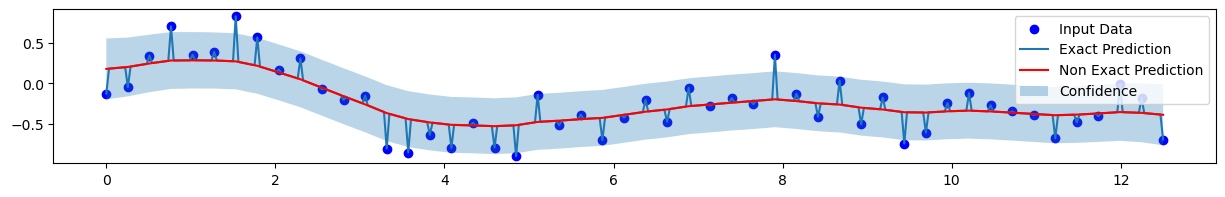

In [34]:
np.random.seed(42)                #x = XX ; y = YY
x = np.linspace(0, 12.5, 50);      y = np.sin(x) * np.exp(-0.25 * x) + np.random.normal(-0.25, 0.25, 50)
X_P = np.linspace(0, 12.5, 393)   ; YA=np.zeros(x.shape)

uk = OrdinaryKriging(x, YA,y,variogram_model="linear",exact_values=False)   ;uk_exact = OrdinaryKriging(x, YA, y, variogram_model="linear")
YP, Y_STD = uk.execute("grid", X_P, np.array([0.0]), backend="loop")        ;YP_exact, Y_STD_exact = uk_exact.execute("grid", X_P, np.array([0.0]), backend="loop")
YP = np.squeeze(YP) ; Y_STD = np.squeeze(Y_STD)                             ;YP_exact = np.squeeze(YP_exact) ; Y_STD_exact = np.squeeze(Y_STD_exact)

fig, ax = plt.subplots(1, 1, figsize=(15, 2))       ; ax.scatter(x, y, label="Input Data", color='b')            
ax.plot(X_P, YP_exact, label="Exact Prediction")    ; ax.plot(X_P, YP, label="Non Exact Prediction", color='r') ; ax.fill_between(X_P,YP-3*Y_STD,YP+3*Y_STD,alpha=0.3,label="Confidence")
ax.legend(loc=1)# ; ax.set_ylim(-1.8, 1.3) ; plt.show()

<font color='blue'> **____________________________________________________________________K_Geo** </font> 

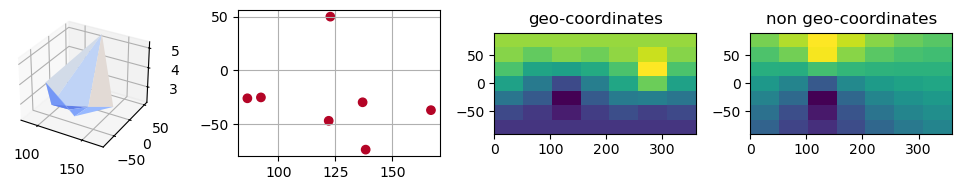

In [35]:
np.random.seed(89239413)  ; N = 7           ; lon = 360.0 * np.random.random(N)      ; lat = 180.0 / np.pi * np.arcsin(2 * np.random.random(N) - 1)  ; z = 3.5 * np.random.rand(N) + 2.0
n='n'                                       ; grid_lon = np.linspace(0.0, 360.0, 7)  ; grid_lat = np.linspace(-90.0, 90.0, 7)                        ; X=lon ; Y=lat ; Z=z

OK = OrdinaryKriging(lon,lat,z,variogram_model="linear",verbose=False,enable_plotting=False,coordinates_type="geographic",) ; z1, ss1 = OK.execute("grid", grid_lon, grid_lat)
OK = OrdinaryKriging(lon, lat, z, variogram_model="linear", verbose=False, enable_plotting=False)                           ; z2, ss2 = OK.execute("grid", grid_lon, grid_lat)

fig = plt.figure(figsize=(10, 2))          ; cmap = matplotlib.colormaps["coolwarm"]
ax=fig.add_subplot(141,projection='3d')    ; ax.plot_trisurf(X,Y,Z, cmap=cm.coolwarm, vmin=np.nanmin(Z), vmax=np.nanmax(Z)); 
ax=fig.add_subplot(142)                    ; plt.scatter(X,Y,c=cmap(Z)[..., :3])           ; plt.grid() 
ax=fig.add_subplot(143)                    ; plt.imshow(z1, extent=[0, 360, -90, 90], origin="lower") ; plt.title("geo-coordinates")
ax=fig.add_subplot(144)                    ; plt.imshow(z2, extent=[0, 360, -90, 90], origin="lower") ; plt.title("non geo-coordinates")
plt.tight_layout(); plt.show()

In [36]:
# We can see that the data point at longitude 122, latitude 50 correctly dominates the kriged results, since it is the closest node in spherical
# distance metric, as longitude differences scale with cos(latitude). When kriging using longitude / latitude linearly, the value for grid points
# with longitude values further away as longitude is now incorrectly weighted equally as latitude.

'''print("Original data:") ; print("Longitude:", lon.astype(int)) ; print("Latitude: ", lat.astype(int)) ; print("z:        ", np.array_str(z, precision=2))
print("\nKrige at 60° latitude:\n======================") ; print("Longitude:", grid_lon) ; print("Value:    ", np.array_str(z1[5, :], precision=2))
print("Sigma²:   ", np.array_str(ss1[5, :], precision=2)) ; print("\nIgnoring curvature:\n=====================") ; print("Value:    ", np.array_str(z2[5, :], precision=2))
print("Sigma²:   ", np.array_str(ss2[5, :], precision=2))'''

'print("Original data:") ; print("Longitude:", lon.astype(int)) ; print("Latitude: ", lat.astype(int)) ; print("z:        ", np.array_str(z, precision=2))\nprint("\nKrige at 60° latitude:\n======================") ; print("Longitude:", grid_lon) ; print("Value:    ", np.array_str(z1[5, :], precision=2))\nprint("Sigma²:   ", np.array_str(ss1[5, :], precision=2)) ; print("\nIgnoring curvature:\n=====================") ; print("Value:    ", np.array_str(z2[5, :], precision=2))\nprint("Sigma²:   ", np.array_str(ss2[5, :], precision=2))'

<font color='blue'> **____________________________________________________________________VTK** </font> 

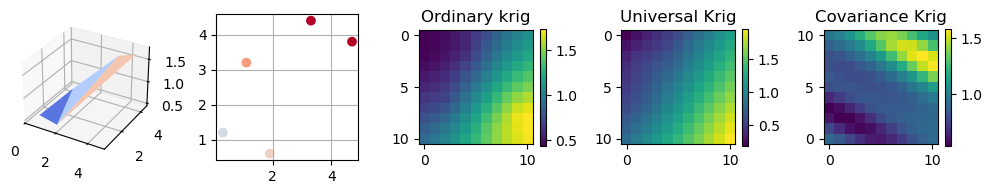

In [37]:
data = np.array([[0.3, 1.2, 0.47],[1.9, 0.6, 0.56],[1.1, 3.2, 0.74],[3.3, 4.4, 1.47],[4.7, 3.8, 1.74],])    ; GX = np.arange(0.0, 5.5, 0.5) ; GY = np.arange(0.0, 5.5, 0.5)
OK = OrdinaryKriging (data[:,0],data[:,1] ,data[:,2] ,variogram_model="linear" ,verbose=False,enable_plotting=False)  ; Z1, ss1 = OK.execute("grid", GX, GY)        
UK = UniversalKriging(data[:,0],data[:,1] ,data[:,2] ,variogram_model="linear" ,drift_terms=["regional_linear"],)     ; Z2, ss2 = UK.execute("grid", GX, GY)

COV = gs.Gaussian(dim=2, len_scale=4, anis=0.2, angles=-0.5, var=0.5, nugget=0.1) ; OK1 = OrdinaryKriging(data[:,0],data[:,1],data[:,2],COV) ;Z3,ss3=OK1.execute("grid",GX,GY)

#kt.write_asc_grid(GX, GY, Z1, filename="output.asc") #; print(data)  
fig = plt.figure(figsize=(10, 2))            ; X=data[:,0] ;Y=data[:,1] ;Z=data[:,2]      ; cmap = matplotlib.colormaps["coolwarm"]
ax=fig.add_subplot(151,projection='3d')      ; ax.plot_trisurf(X,Y,Z, cmap=cm.coolwarm, vmin=np.nanmin(Z), vmax=np.nanmax(Z)) 
ax=fig.add_subplot(152)                      ; plt.scatter(X,Y,c=cmap(Z)[..., :3])        ; plt.grid() 
ax=fig.add_subplot(153); plt.imshow(Z1) ;plt.colorbar(shrink=0.8)    ; plt.title("Ordinary krig")  
ax=fig.add_subplot(154); plt.imshow(Z2) ;plt.colorbar(shrink=0.8)    ; plt.title("Universal Krig")  
ax=fig.add_subplot(155); plt.imshow(Z3, origin="lower")              ; plt.title("Covariance Krig")  ; plt.colorbar(shrink=0.8)   

plt.tight_layout(); plt.show()

#values = np.arange(10 * 10 * 5) ;vtk_array=numpy_to_vtk(values);vtk_array.SetName("values");image=vtk.vtkImageData()      ; image.SetDimensions(10, 10, 5); 
values = Z1                      ;vtk_array=numpy_to_vtk(values);vtk_array.SetName("values");image=vtk.vtkImageData()      ; image.SetDimensions(11, int("".join(map(str, list(GX.shape)))), 1); 
image.GetPointData().SetScalars(vtk_array)  ;MESH=pv.wrap(image); POINTS=MESH.points ;CELL=MESH.cell_data;pd.DataFrame(POINTS).to_csv(TA/'POINTS.csv')
#MESH.plot(show_edges=True) ; print(GY.shape, GX.shape)

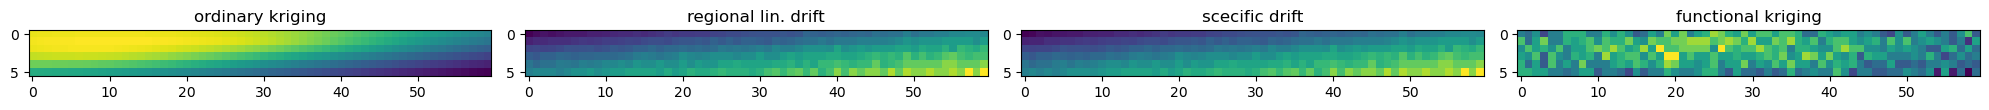

In [38]:
data = np.array([[0.1, 0.1, 0.3, 0.9],[0.2, 0.1, 0.4, 0.8],[0.1, 0.3, 0.1, 0.9],[0.5, 0.4, 0.4, 0.5],[0.3, 0.3, 0.2, 0.7],])

GX = np.arange(0.0, 0.6, 0.05) ; GY = np.arange(0.0, 0.6, 0.01) ; GZ = np.arange(0.0, 0.6, 0.1) ; SP = "specified"; RG="regional_linear" ; func = lambda x, y, z: x

ok3d = OrdinaryKriging3D(data[:,0],data[:,1],data[:,2],data[:,3], variogram_model="linear")                 ;k3d1,ss3d=ok3d.execute("grid", GX, GY, GZ)
uk3d=UniversalKriging3D(data[:,0],data[:,1],data[:,2],data[:,3],variogram_model="linear",drift_terms=[RG],) ;k3d2,ss3d=uk3d.execute("grid", GX, GY, GZ); zg,yg,xg=np.meshgrid(GZ,GY,GX,indexing="ij")
uk3d=UniversalKriging3D(data[:,0],data[:,1],data[:,2],data[:,3],variogram_model="linear",drift_terms=[SP],specified_drift=[data[:,0],data[:,1],data[:,2]],) ;k3d3,ss3d=uk3d.execute("grid",GX,GY,GZ,specified_drift_arrays=[xg,yg,zg])
uk3d = UniversalKriging3D(data[:,0],data[:,1],data[:,2],data[:,3],variogram_model="linear",drift_terms=["functional"],functional_drift=[func],)             ;k3d4, ss3d = uk3d.execute("grid", GX, GY, GZ)

fig = plt.figure(figsize=(20, 20), dpi=100)          
ax=fig.add_subplot(141); plt.imshow(k3d1[:, :, 0]) ; plt.title("ordinary kriging")    ; ax=fig.add_subplot(142); plt.imshow(k3d2[:, :, 0]) ; plt.title("regional lin. drift")    
ax=fig.add_subplot(143); plt.imshow(k3d3[:, :, 0]) ; plt.title("scecific drift")      ; ax=fig.add_subplot(144); plt.imshow(k3d4[:, :, 0]) ; plt.title("functional kriging") ; plt.tight_layout(); plt.show()

In [39]:
print(GZ.shape, GY.shape, GX.shape, k3d1.shape)

(6,) (60,) (12,) (6, 60, 12)


In [ ]:
# pip install -U scikit-learn